In [0]:
#  https://www.kaggle.com/c/otto-group-product-classification-challenge/data

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
%matplotlib inline

# 1. Data Exploration
* Rough overview of the data
* Check missing, duplicated values
* Target and feature distribution, including outliers and patterns
* Understand the meaning of each faeture, their types, correlation etc.

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
print("Train data shape : ", train.shape)
print("Test data shape : ", test.shape)

Train data shape :  (4209, 378)
Test data shape :  (4209, 377)


In [0]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [0]:
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [0]:
# missing value, duplicated value
print ('missing value =', train.isnull().sum().sum())
print ('duplicated rows =', train.duplicated().sum())
print ('duplicated columns=',train.columns.duplicated().sum())

missing value = 0
duplicated rows = 0
duplicated columns= 0


In [0]:
# data type
print (train.info(),'\n')
# y statistics
print ('Basic statistics of target y\n',train['y'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB
None 

Basic statistics of target y
 count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64


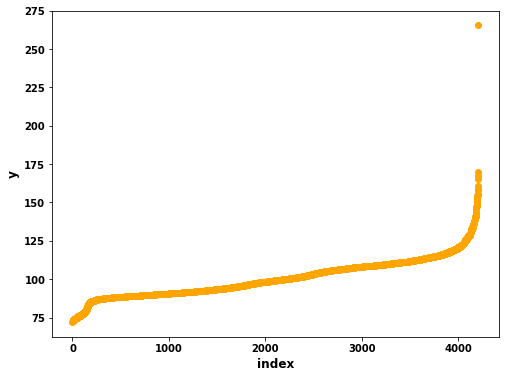

In [0]:
# check target y
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['y'].values), color='orange')
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)

/home/hwei7/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hwei7/py3.6/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


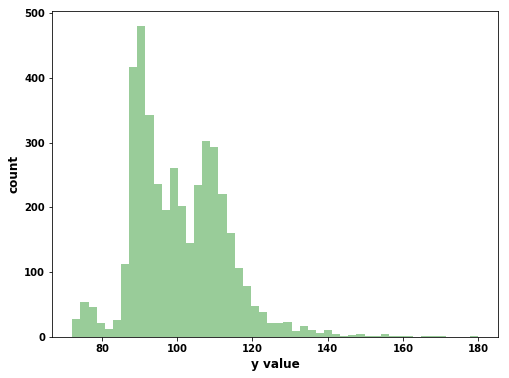

In [0]:
# distribution of y
ulimit = 180
train['y'].ix[train['y']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(train['y'].values, bins=50, kde=False, color='green')
plt.xlabel('y value', fontsize=12)
plt.ylabel('count', fontsize=12)

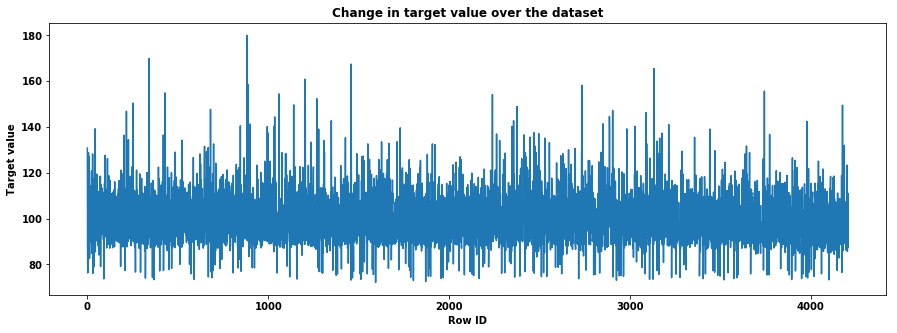

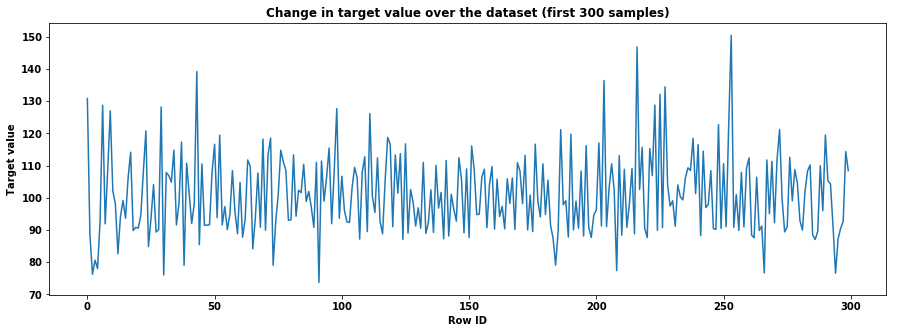

In [0]:
# correlation of ID in train and test, if a sequence pattern can be observed
plt.figure(figsize=(15, 5))
plt.plot(train['y'])
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset', fontweight='bold')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(train['y'].values[:300])
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset (first 300 samples)', fontweight='bold')
print()

### * Note: Plenty of exploration and visulization can be done, other good examples are:
* https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-mercedes
* https://www.kaggle.com/deadskull7/78th-place-solution-private-lb-0-55282-top-2

# 2. Feature Engineering
* High dimension feature need to be taken care of
* Check duplicated and constant feaeture
* Check low count categorical features
* Principal Component Analysis, Independent Component Analysis, Truncated SVD are common methods

In [0]:
# Categorical features
cat_cols = []
for c in train.columns:
    if train[c].dtype == 'object':
        cat_cols.append(c)
print('Categorical columns:', cat_cols)

# Dublicate features
d = {}; done = []
cols = train.columns.values
for c in cols: 
    d[c]=[]
for i in range(len(cols)):
    if i not in done:
        for j in range(i+1, len(cols)):
            if all(train[cols[i]] == train[cols[j]]):
                done.append(j)
                d[cols[i]].append(cols[j])
dub_cols = []
for k in d.keys():
    if len(d[k]) > 0: 
        # print k, d[k]
        dub_cols += d[k]        
print('Dublicates:', dub_cols)

# Constant columns
const_cols = []
for c in cols:
    if len(train[c].unique()) == 1:
        const_cols.append(c)
print('Constant cols:', const_cols)

col_del = dub_cols+const_cols # these features can be deleted

Categorical columns: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']
Dublicates: ['X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347', 'X382', 'X232', 'X279', 'X35', 'X37', 'X39', 'X302', 'X113', 'X134', 'X147', 'X222', 'X102', 'X214', 'X239', 'X76', 'X324', 'X248', 'X253', 'X385', 'X172', 'X216', 'X213', 'X84', 'X244', 'X122', 'X243', 'X320', 'X245', 'X94', 'X242', 'X199', 'X119', 'X227', 'X146', 'X226', 'X326', 'X360', 'X262', 'X266', 'X247', 'X254', 'X364', 'X365', 'X296', 'X299']
Constant cols: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']


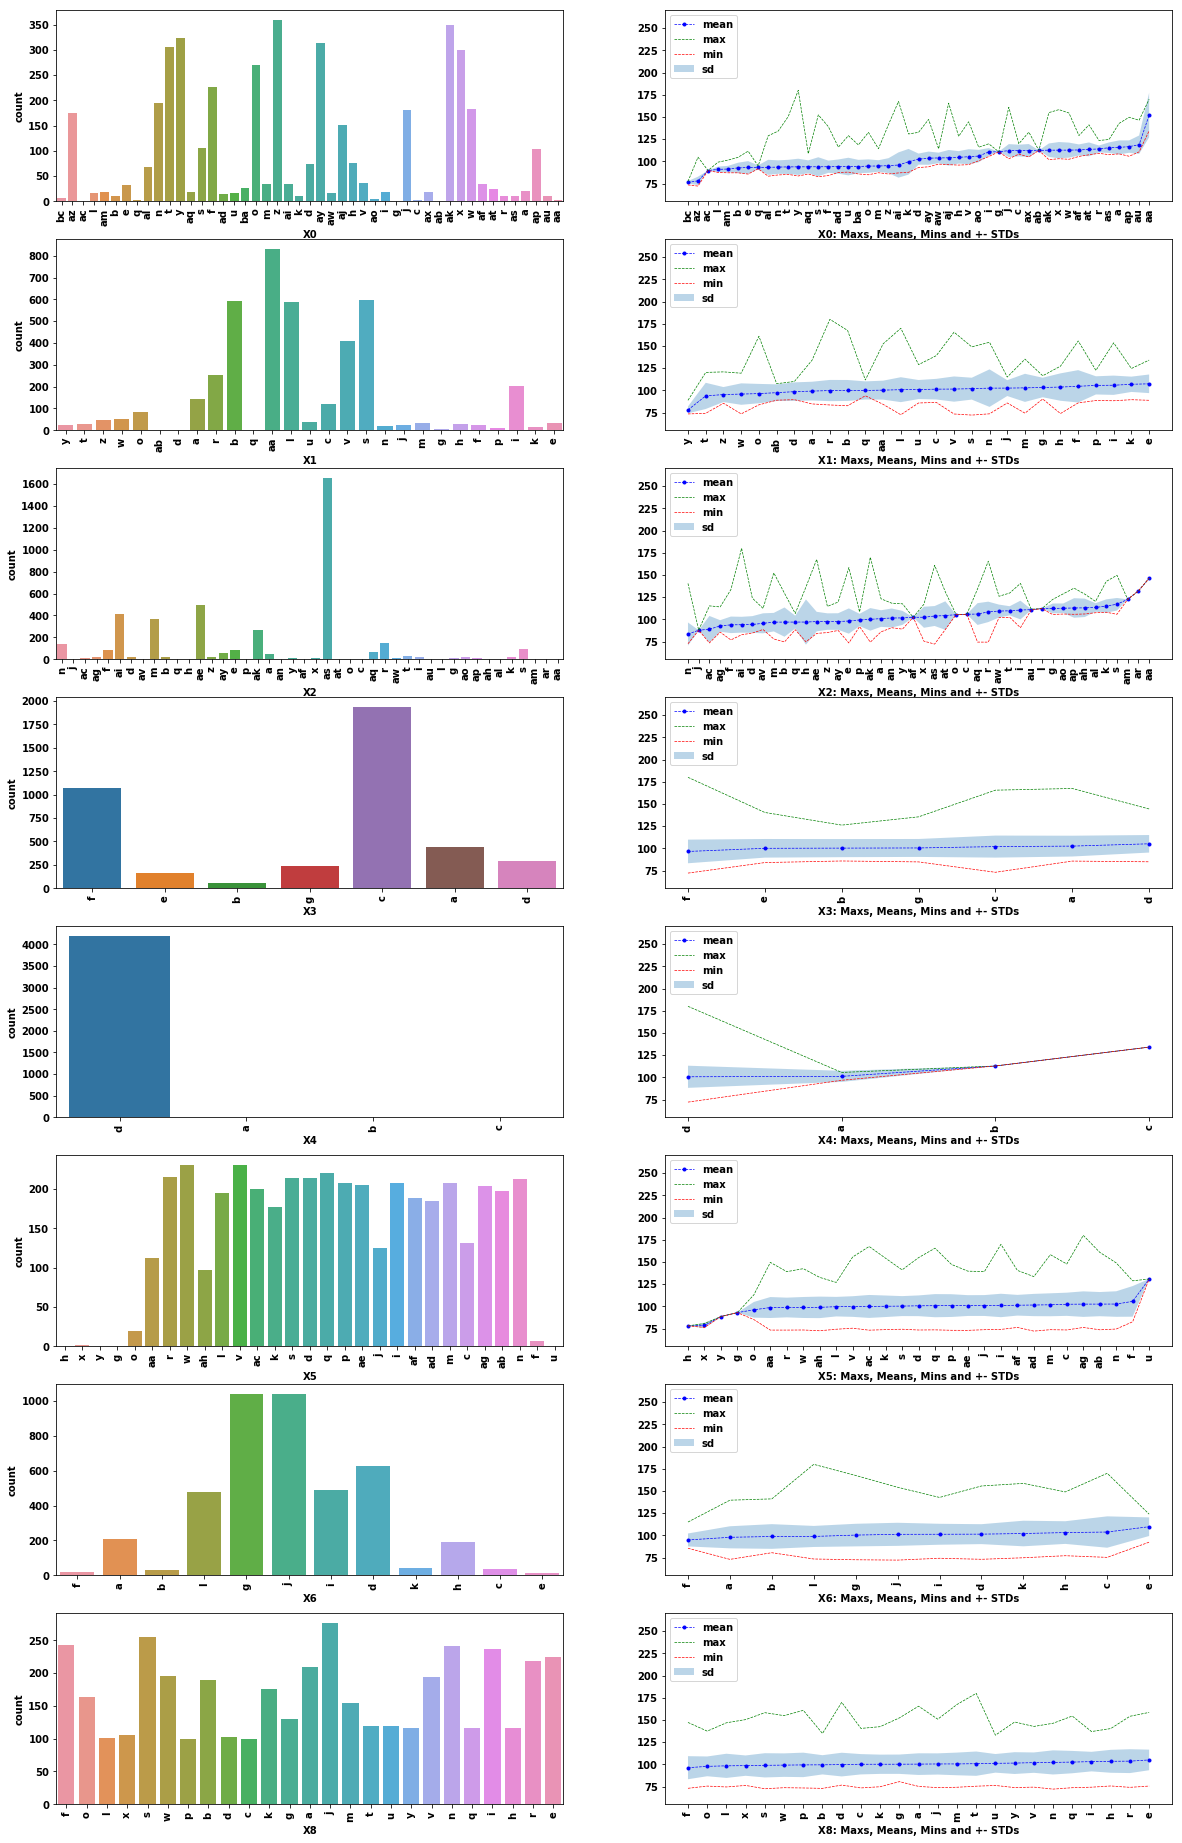

In [0]:
# check for low count sub-categories in category features
plt.figure(figsize=(20,33)) 
for i in range(len(cat_cols)):
    c = cat_cols[i]
    
    means = train.groupby(c).y.mean()
    stds = train.groupby(c).y.std().fillna(0)
    maxs = train.groupby(c).y.max()
    mins = train.groupby(c).y.min()
    
    ddd = pd.concat([means, stds, maxs, mins], axis=1); 
    ddd.columns = ['means', 'stds', 'maxs', 'mins']
    ddd.sort_values('means', inplace=True)
    
    plt.subplot(8,2,2*i+1)
    ax = sns.countplot(train[c], order=ddd.index.values)
    plt.xticks(rotation=90)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
#         ax.annotate('{:.0f}'.format(y), (x.mean(), y), ha='center', va='bottom')

    plt.subplot(8,2,2*i+2)
    plt.fill_between(range(len(train[c].unique())), 
                     ddd.means.values - ddd.stds.values,
                     ddd.means.values + ddd.stds.values,
                     alpha=0.3, label='sd'
                    )
    plt.xticks(range(len(train[c].unique())), ddd.index.values,rotation=90)
    plt.plot(ddd.means.values, color='b', marker='.', linestyle='dashed', linewidth=0.7, label ='mean')
    plt.plot(ddd.maxs.values, color='g', linestyle='dashed', linewidth=0.7,label ='max')
    plt.plot(ddd.mins.values, color='r', linestyle='dashed', linewidth=0.7, label='min')
    plt.legend(loc='upper left')
    plt.xlabel(c + ': Maxs, Means, Mins and +- STDs')
    plt.ylim(55, 270)
    


In [0]:
# combine train and test
train['if_train'] = 1; test['if_train'] = 0
df = pd.concat([train, test], axis=0, copy=True, sort=False)
# Reset index
df.reset_index(drop=True, inplace=True)

In [0]:
# delete constant and duplicated columns
df_1 = df.drop(columns=col_del)

In [0]:
# fill all the less frequent categorical sub-features  (<1%) with 'uncommon'
# this is optional, proceed with caution, what's the risk?
for item in cat_cols:
    try:
        counts = df_1[item].value_counts()
        list_less = counts[counts <= 85].index # <1% of total
        tmp1 = df_1[item].replace(list_less, 'uncommon')
        tmp1= pd.DataFrame(tmp1)
        df_1 = pd.concat([tmp1, df_1.drop([item], axis =1)], axis =1)
    except:
        pass

In [0]:
# label encoding the categorical features for dimension reduction
# label encoding vs. one-hot encoding? 
for c in df_1.columns:
    if df_1[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(df_1[c].values))
        df_1[c] = lbl.transform(list(df_1[c].values))

In [0]:
# seperate train and test
df_1.set_index('ID', inplace=True)
df_train = df_1[df_1['if_train']==1]
df_test = df_1[df_1['if_train']==0]

In [0]:
df_train.head()

,X8,X6,X5,X4,X3,X2,X1,X0,y,X10,...,X374,X375,X376,X377,X378,X379,X380,X383,X384,if_train
ID,,,,,,,,,,,,,,,,,,,,,
0,14,5,20,0,0,13,10,14,130.81,0,...,0,0,0,1,0,0,0,0,0,1
6,14,7,20,0,4,13,9,14,88.53,0,...,0,1,0,0,0,0,0,0,0,1
7,23,5,20,0,2,10,11,5,76.26,0,...,0,0,0,0,0,0,0,0,0,1
9,4,7,20,0,5,10,9,5,80.62,0,...,0,0,0,0,0,0,0,0,0,1
13,13,1,20,0,5,10,10,5,78.02,0,...,0,0,0,0,0,0,0,0,0,1


In [0]:
df_test.head()

,X8,X6,X5,X4,X3,X2,X1,X0,y,X10,...,X374,X375,X376,X377,X378,X379,X380,X383,X384,if_train
ID,,,,,,,,,,,,,,,,,,,,,
1,22,0,20,0,5,10,10,5,NaN,0,...,0,0,0,0,1,0,0,0,0,0
2,24,2,20,0,0,2,2,13,NaN,0,...,0,0,0,1,0,0,0,0,0,0
3,9,5,20,0,5,5,10,5,NaN,0,...,0,0,0,0,1,0,0,0,0,0
4,13,7,20,0,5,10,5,5,NaN,0,...,0,0,0,0,1,0,0,0,0,0
5,12,4,20,0,2,5,8,15,NaN,0,...,0,1,0,0,0,0,0,0,0,0


In [0]:
# use different feature reduction methods

n_comp = 20 # a hyper-parameter 

# tSVD, what's the difference bewteen PCA and SVD? 
# https://arxiv.org/pdf/1404.1100.pdf
tsvd = TruncatedSVD(n_components=n_comp, random_state=2061)
tsvd_results_train = tsvd.fit_transform(df_train.drop(['y','if_train'], axis=1))
tsvd_results_test = tsvd.transform(df_test.drop(['y','if_train'], axis=1))

# PCA
pca = PCA(n_components=n_comp, random_state=2061)
pca2_results_train = pca.fit_transform(df_train.drop(['y','if_train'], axis=1))
pca2_results_test = pca.transform(df_test.drop(['y','if_train'], axis=1))
                                  
# ICA
ica = FastICA(n_components=n_comp, random_state=2061)
ica2_results_train = ica.fit_transform(df_train.drop(['y','if_train'], axis=1))
ica2_results_test = ica.transform(df_test.drop(['y','if_train'], axis=1))

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=2061)
grp_results_train = grp.fit_transform(df_train.drop(['y','if_train'], axis=1))
grp_results_test = grp.transform(df_test.drop(['y','if_train'], axis=1))

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=2061)
srp_results_train = srp.fit_transform(df_train.drop(['y','if_train'], axis=1))
srp_results_test = srp.transform(df_test.drop(['y','if_train'], axis=1))

(-0.1, 21)

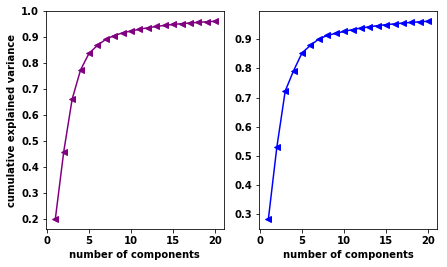

In [0]:
# n_components is a hyper-paramter, in SVD and PCA, variance ratio curve is shown
plt.figure(figsize=(7,4))
plt.subplot(121)
plt.plot(np.arange(1,21),np.cumsum(tsvd.explained_variance_ratio_), color='purple',marker='<')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim((-0.1,21))

plt.subplot(122)
plt.plot(np.arange(1,21),np.cumsum(pca.explained_variance_ratio_), color='blue', marker='<')
plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
plt.xlim((-0.1,21))

# 3. Model Selection
* Nnumerous things can be tested out here, feel free to add

In [0]:
from sklearn.utils import shuffle
y_train = df_train['y'].values

tsvd_train, tsvd_valid, y_tsvd_train, y_tsvd_valid = train_test_split(srp_results_train, y_train, 
                                                                      test_size=0.2, random_state=2061)

In [0]:
gridsearch_params = [
    (eta, subsample,n_trees, max_depth)
    for eta in [0.03, 0.05, 0.07] 
    for subsample in [0.5,0.6,0.7]
    for n_trees in [200,300,400]
    for max_depth in [3,4,5]
]

gridsearch_params

def xgb_r2_score(preds,dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

In [0]:
param = {}
max_r2 = float("-inf")
best_params = None

xg_train = xgb.DMatrix(tsvd_train, label=y_tsvd_train)

for eta, subsample, n_trees, max_depth in (gridsearch_params):
    print("CV with eta={},subsample ={}, n_trees={}, max_depth={}".format(eta,subsample,n_trees,max_depth))
    param['objective'] = 'reg:linear'
    param['max_depth'] = max_depth
    param['n_trees'] = n_trees
    param['eta'] = eta
    param['subsample'] = subsample
    param['nthread'] = 12
    param['verbosity'] = 0

    cv_results = xgb.cv(
        param,
        xg_train,
        seed=2061,
        nfold=3,
        num_boost_round = 600,
        early_stopping_rounds=10, 
        feval = xgb_r2_score,
        show_stdv=False
    )

    mean_r2 = cv_results['test-r2-mean'].max()
    if mean_r2 > max_r2:
        max_r2 = mean_r2
        best_params = (eta, subsample, n_trees, max_depth)

print("Best params: eta{},subsample{},n_trees{},max_depth{}, r2: {}".format(best_params[0], best_params[1],best_params[2],best_params[3], max_r2))

In [0]:
best_params

(0.05, 0.7, 200, 5)

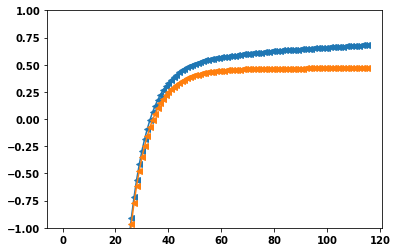

In [0]:
# change of r2 in train and valid data 
plt.plot(cv_results['train-r2-mean'], marker='<')
plt.plot(cv_results['test-r2-mean'],marker='<')
plt.ylim(-1,1)

In [0]:
d_train = xgb.DMatrix(tsvd_train, label=y_tsvd_train)
d_valid = xgb.DMatrix(tsvd_valid, label=y_tsvd_valid)
#best_params = (eta, subsample, n_trees, max_depth)

xgb_params = {
    'n_trees': best_params[2], 
    'eta': best_params[0],
    'max_depth': best_params[3],
    'subsample': best_params[1],
    'objective': 'reg:linear',
    'base_score': np.mean(y_tsvd_train), # base prediction = mean(target)
    'silent': 1
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

best_model = xgb.train(xgb_params, d_train, 6000 , watchlist, early_stopping_rounds=70, feval=xgb_r2_score, maximize=True, verbose_eval=10)

[0]	train-rmse:12.0308	valid-rmse:12.9799	train-r2:0.041177	valid-r2:0.036998
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 70 rounds.
[10]	train-rmse:10.4731	valid-rmse:11.492	train-r2:0.273387	valid-r2:0.245116
[20]	train-rmse:9.54823	valid-rmse:10.628	train-r2:0.396055	valid-r2:0.35436
[30]	train-rmse:8.98307	valid-rmse:10.1607	train-r2:0.465434	valid-r2:0.409884
[40]	train-rmse:8.61117	valid-rmse:9.92118	train-r2:0.50878	valid-r2:0.437383
[50]	train-rmse:8.35673	valid-rmse:9.79444	train-r2:0.53738	valid-r2:0.451666
[60]	train-rmse:8.1572	valid-rmse:9.7072	train-r2:0.559208	valid-r2:0.46139
[70]	train-rmse:7.99001	valid-rmse:9.66	train-r2:0.577092	valid-r2:0.466616
[80]	train-rmse:7.8448	valid-rmse:9.62604	train-r2:0.592323	valid-r2:0.47036
[90]	train-rmse:7.73517	valid-rmse:9.60487	train-r2:0.603638	valid-r2:0.472686
[100]	train-rmse:7.62331	valid-rmse:9.57358	train-r2:0.615019	valid-r2:0.476117
[11

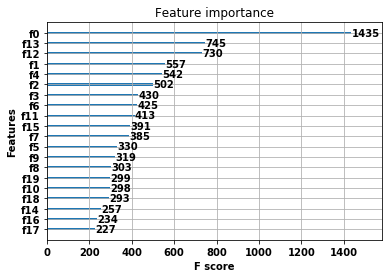

In [0]:
# SVD component f0 is also the one with highest feature importance, but f1 is the next one
# any explanation?
xgb.plot_importance(best_model)

In [0]:
# save model, not needed in this case 

model_name = 'best_model_3_12.sav'
joblib.dump(best_model, model_name) # 'compress' can be used if model is large

['best_model_3_12.sav']

# 4. Prediction

In [0]:
d_predict = xgb.DMatrix(tsvd_results_test)
ypred = best_model.predict(d_predict)
# ypred.to_csv('predict.csv')